In [1]:
import numpy as np
import matplotlib.pyplot as plt
import functions as func

from tqdm.autonotebook import tqdm
import emcee
from multiprocessing import Pool
from skimage.metrics import structural_similarity as ssim
import cv2
import os
import re
import pandas as pd
from radar_functions import *

# import own modules
import functions as func
from data_structures import ObsData, LightCurve, PartialLightCurve
from mcmc import ln_prob, ln_prior, ln_posterior, theor_curve

/tmp/ipykernel_1622803/3182643935.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def ln_wrapper(params: tuple, radar_image_list: RadarImageParameters, radar_images: list, position_vecs, 
               lightcurve: LightCurve, earth_data: ObsData, sun_data: ObsData):
    chi2_radar = ln_posterior_radar(params, radar_image_list, radar_images, position_vecs)
    chi2_lc = ln_posterior(params, lightcurve, earth_data, sun_data)
    return 6*chi2_radar + chi2_lc

In [3]:
def ln_posterior_radar(params: tuple, radar_image_params: RadarImageParameters, radar_images: list, position_vecs):
    """
    calculates chi2 for the modeled lightcurve with the given parameters
    """
    parameters = Parameters()
    mult = 450
    parameters.a1 = params[0] * mult
    parameters.b1 = params[1] * mult
    parameters.c1 = params[2] * mult
    parameters.a2 = params[3] * mult
    parameters.b2 = params[4] * mult
    parameters.c2 = params[5] * mult
    parameters.l = params[6]
    parameters.b = params[7] 
    parameters.phi0 = params[8] 
    #number of points in latitude and longitude used in ray tracing
    cosl = math.cos(parameters.l)
    sinl = math.sin(parameters.l)
    cosb = math.cos(parameters.b)
    sinb = math.sin(parameters.b)
    primary = EllipsoidR(parameters.a1, parameters.b1, parameters.c1,
                    -(parameters.a1+parameters.a2)
                    *parameters.a2*parameters.b2*parameters.c2
                    / (parameters.a1*parameters.b1*parameters.c1
                       +parameters.a2*parameters.b2*parameters.c2))
    secondary = EllipsoidR(parameters.a2,parameters.b2,parameters.c2,
                      (parameters.a1+parameters.a2)
                      *parameters.a1*parameters.b1*parameters.c1
                      / (parameters.a1*parameters.b1*parameters.c1
                         +parameters.a2*parameters.b2*parameters.c2))
    diff_total = []
    #subplot(r,c) provide the no. of rows and columns
    for idx_img in range(radar_image_params.N_points):
        if radar_image_params.presence[idx_img] == 1:
            phi = 2*math.pi*(radar_image_params.jd[idx_img]-59185.77807)/parameters.P + parameters.phi0
            sinphi = math.sin(phi)
            cosphi= math.cos(phi)
            ex0 = position_vecs['x'].iloc[idx_img]
            ey0 = position_vecs['y'].iloc[idx_img]
            ez0 = position_vecs['z'].iloc[idx_img]
            ex,ey,ez = rotate(ex0,ey0,ez0,
                              sinl,cosl,sinb,cosb,
                              sinphi,cosphi)
            observed_radar_brightness = radar_images[idx_img]
            theoretical_radar_brightness_list = theoretical_radar_image(primary=primary,
                                                                        secondary=secondary,
                                                                        ex=ex, ey=ey, ez=ez,
                                                                        P=parameters.P, 
                                                                        N_radar_pixels=radar_image_params.size_px[idx_img],
                                                                        dr=radar_image_params.dr[idx_img], 
                                                                        dnu=radar_image_params.dnu[idx_img], Nalpha=30)
            saturate_theoretical_radar_image(theoretical_radar_brightness_list, parameters)
            
            # shift theoretical image 
            theoretical_radar_brightness = np.array(theoretical_radar_brightness_list) - 0.1
            x_center_theor, y_center_theor = func.center_of_mass(theoretical_radar_brightness)
            x_center_obs, y_center_obs = func.center_of_mass(observed_radar_brightness - np.median(observed_radar_brightness))
            shift_x = x_center_obs - x_center_theor
            shift_y = y_center_obs - y_center_theor
            try:
                theoretical_radar_brightness = np.roll(theoretical_radar_brightness, int(shift_y), axis=1)
                theoretical_radar_brightness = np.roll(theoretical_radar_brightness, int(shift_x), axis=0)
            except:
                print(shift_x, shift_y)
                continue
            # calculate difference between theoretical and observed images
            diff = img_difference(observed_radar_brightness, theoretical_radar_brightness)
            diff_total.append(diff)
    
    chi2 = np.sum(np.array(diff_total))
    return -0.5 * chi2

def images_diff(params: tuple, radar_image_params: RadarImageParameters, radar_images: list, position_vecs, mult=400):
    """
    calculates chi2 for the modeled lightcurve with the given parameters
    """
    parameters = Parameters()
    parameters.a1 = params[0] * mult
    parameters.b1 = params[1] * mult
    parameters.c1 = params[2] * mult
    parameters.a2 = params[3] * mult
    parameters.b2 = params[4] * mult
    parameters.c2 = params[5] * mult
    parameters.l = params[6]
    parameters.b = params[7] 
    parameters.phi0 = params[8] 
    #number of points in latitude and longitude used in ray tracing
    cosl = math.cos(parameters.l)
    sinl = math.sin(parameters.l)
    cosb = math.cos(parameters.b)
    sinb = math.sin(parameters.b)
    primary = EllipsoidR(parameters.a1, parameters.b1, parameters.c1,
                    -(parameters.a1+parameters.a2)
                    *parameters.a2*parameters.b2*parameters.c2
                    / (parameters.a1*parameters.b1*parameters.c1
                       +parameters.a2*parameters.b2*parameters.c2))
    secondary = EllipsoidR(parameters.a2,parameters.b2,parameters.c2,
                      (parameters.a1+parameters.a2)
                      *parameters.a1*parameters.b1*parameters.c1
                      / (parameters.a1*parameters.b1*parameters.c1
                         +parameters.a2*parameters.b2*parameters.c2))
    imgs = []
    diff_total = []
    #subplot(r,c) provide the no. of rows and columns
    for idx_img in range(radar_image_params.N_points):
        if radar_image_params.presence[idx_img] == 1:
            phi = 2*math.pi*(radar_image_params.jd[idx_img]-59185.77807)/parameters.P + parameters.phi0
            sinphi = math.sin(phi)
            cosphi= math.cos(phi)
            ex0 = position_vecs['x'].iloc[idx_img]
            ey0 = position_vecs['y'].iloc[idx_img]
            ez0 = position_vecs['z'].iloc[idx_img]
            ex,ey,ez = rotate(ex0,ey0,ez0,
                              sinl,cosl,sinb,cosb,
                              sinphi,cosphi)
            observed_radar_brightness = radar_images[idx_img]
            theoretical_radar_brightness_list = theoretical_radar_image(primary=primary,
                                                                        secondary=secondary,
                                                                        ex=ex, ey=ey, ez=ez,
                                                                        P=parameters.P, 
                                                                        N_radar_pixels=radar_image_params.size_px[idx_img],
                                                                        dr=radar_image_params.dr[idx_img], 
                                                                        dnu=radar_image_params.dnu[idx_img], 
                                                                        Nalpha=30)
            saturate_theoretical_radar_image(theoretical_radar_brightness_list, parameters)
            
            # shift theoretical image 
            theoretical_radar_brightness = np.array(theoretical_radar_brightness_list) - 0.1
            x_center_theor, y_center_theor = func.center_of_mass(theoretical_radar_brightness)
            x_center_obs, y_center_obs = func.center_of_mass(observed_radar_brightness - np.median(observed_radar_brightness))
            shift_x = x_center_obs - x_center_theor
            shift_y = y_center_obs - y_center_theor
            theoretical_radar_brightness = np.roll(theoretical_radar_brightness, int(shift_y), axis=1)
            theoretical_radar_brightness = np.roll(theoretical_radar_brightness, int(shift_x), axis=0)
            # calculate difference between theoretical and observed images
            diff = img_difference(observed_radar_brightness, theoretical_radar_brightness)
            imgs.append((observed_radar_brightness-theoretical_radar_brightness))
            diff_total.append(diff)
    
    chi2 = np.sum(np.array(diff_total))
    return diff_total, imgs

def ln_prior(params: tuple) -> float:
    """constrains parameters to be in bounds, returns -inf if not in bounds,
    does not allow MCMC walkers to wander off"""
    a1, b1, c1, a2, b2, c2, lon, lat, init_phase = params
    # if any parameter is out of bounds, return -inf
    #a1_cond = 0.25 <= a1 <= 3
    b1_cond = 0.25 <= b1 <= a1
    c1_cond = 0.25 <= c1 <= b1
    a2_cond = 0.25 <= a2 <= a1
    b2_cond = 0.25 <= b2 <= a2
    c2_cond = 0.25 <= c2 <= b2
    lon_cond = 0 <= lon <= 2 * math.pi
    lat_cond = -math.pi/2 <= lat <= math.pi/2
    init_phase_cond = 0 <= init_phase <= 2 * math.pi
    if (b1_cond and c1_cond
            and a2_cond and b2_cond and c2_cond
            and lon_cond and lat_cond and init_phase_cond):
        return 0
    # if not, return -inf (this ensures walkers does not walk out of bounds)
    return -np.inf

def ln_prob(params: tuple, radar_image_list: RadarImageParameters, radar_images: list, position_vecs, 
               lightcurve: LightCurve, earth_data: ObsData, sun_data: ObsData):
     """wrapper for ln posterior, returns chi2 if in bounds, else -inf"""
     ln_p = ln_prior(params)
     if not np.isfinite(ln_p):
         return -np.inf
     return ln_p + ln_wrapper(params, radar_image_list, radar_images, position_vecs, 
                              lightcurve, earth_data, sun_data)

def denoise_img(img: np.array) -> np.array:
    """denoises image"""
    img = (img * 255).astype(np.uint8)
    dst = cv2.fastNlMeansDenoising(img, 20,20,5,21) / 255
    dst = dst - np.quantile(dst, 0.1) 
    dst[dst < 0] = 0
    dst = dst / np.max(dst)
    return dst

def saturate_theoretical_radar_image(brightness_list, parameters):
    N_radar_pixels = len(brightness_list)
    parameters.radar_saturation = 2000
    k = (1 - parameters.radar_background) / parameters.radar_saturation
    b = parameters.radar_background
    for i in range(N_radar_pixels):
        for j in range(N_radar_pixels):
            if brightness_list[i][j] > parameters.radar_saturation:
                brightness_list[i][j] = parameters.radar_saturation
            brightness_list[i][j] = k*brightness_list[i][j] + b
    return brightness_list

def img_difference(observed, theoretical):
    return np.sum((observed - theoretical)**2, axis=None)

In [4]:
# get state vectors of the Earth and the Sun from JPL Horizons database
asteroid_name = "2000 WO107" 
lightcurve = LightCurve()  # container to store partial lightcurves
earth_data = ObsData()     # store earth vectors
sun_data = ObsData()       # store sun vectors
# get names of the lightcurve files
fnames = [f for f in os.listdir('light_curves') if re.match(r'.*\.dat', f)]
fnames.sort()
# read and parse partial lightcurve files
for fname in fnames[:4]:
    part_curve = pd.read_fwf(f'light_curves/{fname}', header=None, names=['epoch', 'mag', 'mag_err'])
    lightcurve += PartialLightCurve(part_curve)
for fname in fnames[4:]:
    part_curve = pd.read_csv(f'light_curves/{fname}', header=None, names=['epoch', 'mag', 'mag_err'], sep='\t')
    part_curve['epoch'] = part_curve['epoch'].astype(float) + 2400000.5
    lightcurve += PartialLightCurve(part_curve)
# sort lightcurves in the ascending order of the epoch
lightcurve.sort_lightcurves()
start_epoch = lightcurve.joined['epoch'].min()
reduc_epochs = lightcurve.joined['epoch'] - start_epoch

In [5]:
# query JPL Horizons to get state vectors of the Sun and the Earth
for part_curve in tqdm(lightcurve, total=len(lightcurve), desc='Querying JPL Horizons'):
    epochs = part_curve.data.epoch.to_list()
    state_vecs_sun = func.get_object_orbit(asteroid_name, epochs=epochs,  location='@10', data_type='vectors') 
    # @399 - Earth
    state_vecs_earth = func.get_object_orbit(asteroid_name, epochs=epochs,  location='@399', data_type='vectors') 
    # calculate reduc epoch (counting from start epoch)
    state_vecs_sun['reduc_epoch'] = state_vecs_sun['epoch'] - start_epoch
    state_vecs_earth['reduc_epoch'] = state_vecs_earth['epoch'] - start_epoch
    # inverse signs of vectors
    state_vecs_sun[['x', 'y', 'z']] = -state_vecs_sun[['x', 'y', 'z']]
    state_vecs_earth[['x', 'y', 'z']] = -state_vecs_earth[['x', 'y', 'z']]
    sun_data += state_vecs_sun
    earth_data += state_vecs_earth

Querying JPL Horizons:   0%|          | 0/13 [00:00<?, ?it/s]

In [6]:
radar_image_params = RadarImageParameters("radar_data/data.txt")
# radar_images_obs = [np.array(read_observed_radar_image(radar_image_params,idx_img)) for idx_img in range(radar_image_params.N_points)]
radar_images_obs = [denoise_img(np.array(read_observed_radar_image(radar_image_params,idx_img))) 
                    for idx_img in range(radar_image_params.N_points)]


query_dates = [radar_image_params.jd[idx_img] + 2400000.5 for idx_img in range(len(radar_image_params.jd))]
state_vecs_earth = func.get_object_orbit('2000 WO107', epochs=query_dates,  location='@399', data_type='vectors')
state_vecs_earth['r'] = np.sum(state_vecs_earth[['x', 'y', 'z']] ** 2, axis=1)**0.5
position_vecs = (state_vecs_earth[['x', 'y', 'z']].T / state_vecs_earth['r']).T
position_vecs.to_csv('input_data/position_vecs.csv', index=False)

In [13]:
n_procs = 12  # number of processes (cores) to use
nwalkers = n_procs * 3  # number of probe points

coeff = 0.2
init_ps = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0.0]
init_params = np.array([init_ps[0]  + coeff * np.random.randn(nwalkers),  # b1
                        init_ps[1]  + coeff * np.random.randn(nwalkers),  # c1
                        init_ps[2]  + coeff * np.random.randn(nwalkers),  # a2
                        init_ps[3]  + coeff * np.random.randn(nwalkers),  # b2
                        init_ps[4]  + coeff * np.random.randn(nwalkers),  # c2
                        init_ps[5]  + coeff * np.random.randn(nwalkers),  # c2
                        0 + np.random.uniform(low=0, high=2 * math.pi, size=nwalkers), 
                        0 + np.random.uniform(low=-math.pi /2, high=math.pi /2, size=nwalkers), 
                        0 + np.random.uniform(low=0, high=2 * math.pi, size=nwalkers)]).T
ndim = np.size(init_params, axis=1)  # number of parameters
init_params = init_params.astype(float)

In [14]:
with Pool(processes=n_procs) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_prob, 
                                    args=(radar_image_params, radar_images_obs, position_vecs,
                                          lightcurve, earth_data, sun_data), 
                                    pool=pool,
                                    #moves=emcee.moves.GaussianMove(cov=cov_mat))
                                    moves=[(emcee.moves.DEMove(), 0.8),
                                           (emcee.moves.DESnookerMove(), 0.2)])
    # Run the MCMC sampler
    nsteps = 100
    burn_in = 1
    # starting points for every walker
    #init_p = np.random.rand(nwalkers, ndim)
    pos, prob, state = sampler.run_mcmc(init_params, nsteps, progress=True)
    # Get the samples after burn-in
    samples = sampler.get_chain(discard=burn_in, flat=True)

# Plot the scatter plot of data and fitted model
best_fit_params = np.median(samples, axis=0)
#best_fit_params = np.insert(best_fit_params, 0, 1.0)
fit_curve = theor_curve(best_fit_params, earth_data, sun_data)

  0%|          | 0/100 [00:00<?, ?it/s]/home/igor/anaconda3/envs/sandbox/lib/python3.12/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
 55%|█████▌    | 55/100 [04:17<04:51,  6.48s/it]/home/igor/PycharmProjects/Binary_MCMC/functions.py:100: RuntimeWarning: invalid value encountered in scalar divide
  x_center_of_mass = np.sum(x_indices * image) / total_mass
/home/igor/PycharmProjects/Binary_MCMC/functions.py:101: RuntimeWarning: invalid value encountered in scalar divide
  y_center_of_mass = np.sum(y_indices * image) / total_mass


nan nan


 68%|██████▊   | 68/100 [05:43<03:21,  6.28s/it]/home/igor/PycharmProjects/Binary_MCMC/functions.py:100: RuntimeWarning: invalid value encountered in scalar divide
  x_center_of_mass = np.sum(x_indices * image) / total_mass
/home/igor/PycharmProjects/Binary_MCMC/functions.py:101: RuntimeWarning: invalid value encountered in scalar divide
  y_center_of_mass = np.sum(y_indices * image) / total_mass


nan nan


 77%|███████▋  | 77/100 [06:46<02:46,  7.24s/it]/home/igor/PycharmProjects/Binary_MCMC/functions.py:100: RuntimeWarning: invalid value encountered in scalar divide
  x_center_of_mass = np.sum(x_indices * image) / total_mass
/home/igor/PycharmProjects/Binary_MCMC/functions.py:101: RuntimeWarning: invalid value encountered in scalar divide
  y_center_of_mass = np.sum(y_indices * image) / total_mass


nan nan


 81%|████████  | 81/100 [07:16<02:22,  7.51s/it]/home/igor/PycharmProjects/Binary_MCMC/functions.py:100: RuntimeWarning: invalid value encountered in scalar divide
  x_center_of_mass = np.sum(x_indices * image) / total_mass
/home/igor/PycharmProjects/Binary_MCMC/functions.py:101: RuntimeWarning: invalid value encountered in scalar divide
  y_center_of_mass = np.sum(y_indices * image) / total_mass


nan nan


100%|██████████| 100/100 [09:34<00:00,  5.75s/it]


In [ ]:
# import pickle
# file_pick = open('both_mcmc_26_08.obj', 'wb')
# pickle.dump(sampler, file=file_pick)

In [7]:
import pickle
file_pick = open('both_mcmc_test.obj', 'rb')
#file_pick = open('mcmc_results_keyinterrupt.obj', 'rb')
sampler = pickle.load(file_pick)

In [8]:
samples_flat = sampler.flatchain
samples = sampler.get_chain(flat=True)
flat_ln = sampler.flatlnprobability #[np.isfinite(sampler.flatlnprobability)]
min_arg = flat_ln.argmax()
min_chi = flat_ln[min_arg]
print(f'len_samples_flat: {len(samples_flat)}')
print(f"min_arg: {min_arg}, min_chi: {min_chi}")
best_params = samples_flat[min_arg]
print("""best_params: a1 = {:.2f},  b1 = {:.2f}, c1 = {:.2f},
             a2 = {:.2f}, b2 = {:.2f}, c2 = {:.2f}, 
             lon = {:.2f}, lat = {:.2f}, phase = {:.2f}""".format(*best_params))
#best_params = np.insert(best_params, 0, 1.0)
print('best:      ', [round(param, 3) for param in best_params])

len_samples_flat: 3600
min_arg: 3563, min_chi: -51130.21804731988
best_params: a1 = 1.24,  b1 = 0.83, c1 = 0.71,
             a2 = 0.87, b2 = 0.71, c2 = 0.44, 
             lon = 5.79, lat = -0.99, phase = 6.24
best:       [1.242, 0.829, 0.708, 0.865, 0.709, 0.439, 5.789, -0.99, 6.237]


In [25]:
import pickle
file_pick = open('both_mcmc_test.obj', 'wb')
pickle.dump(sampler, file=file_pick)

/tmp/ipykernel_1622803/1324392594.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.1, h_pad=-0.4, w_pad=0.0)


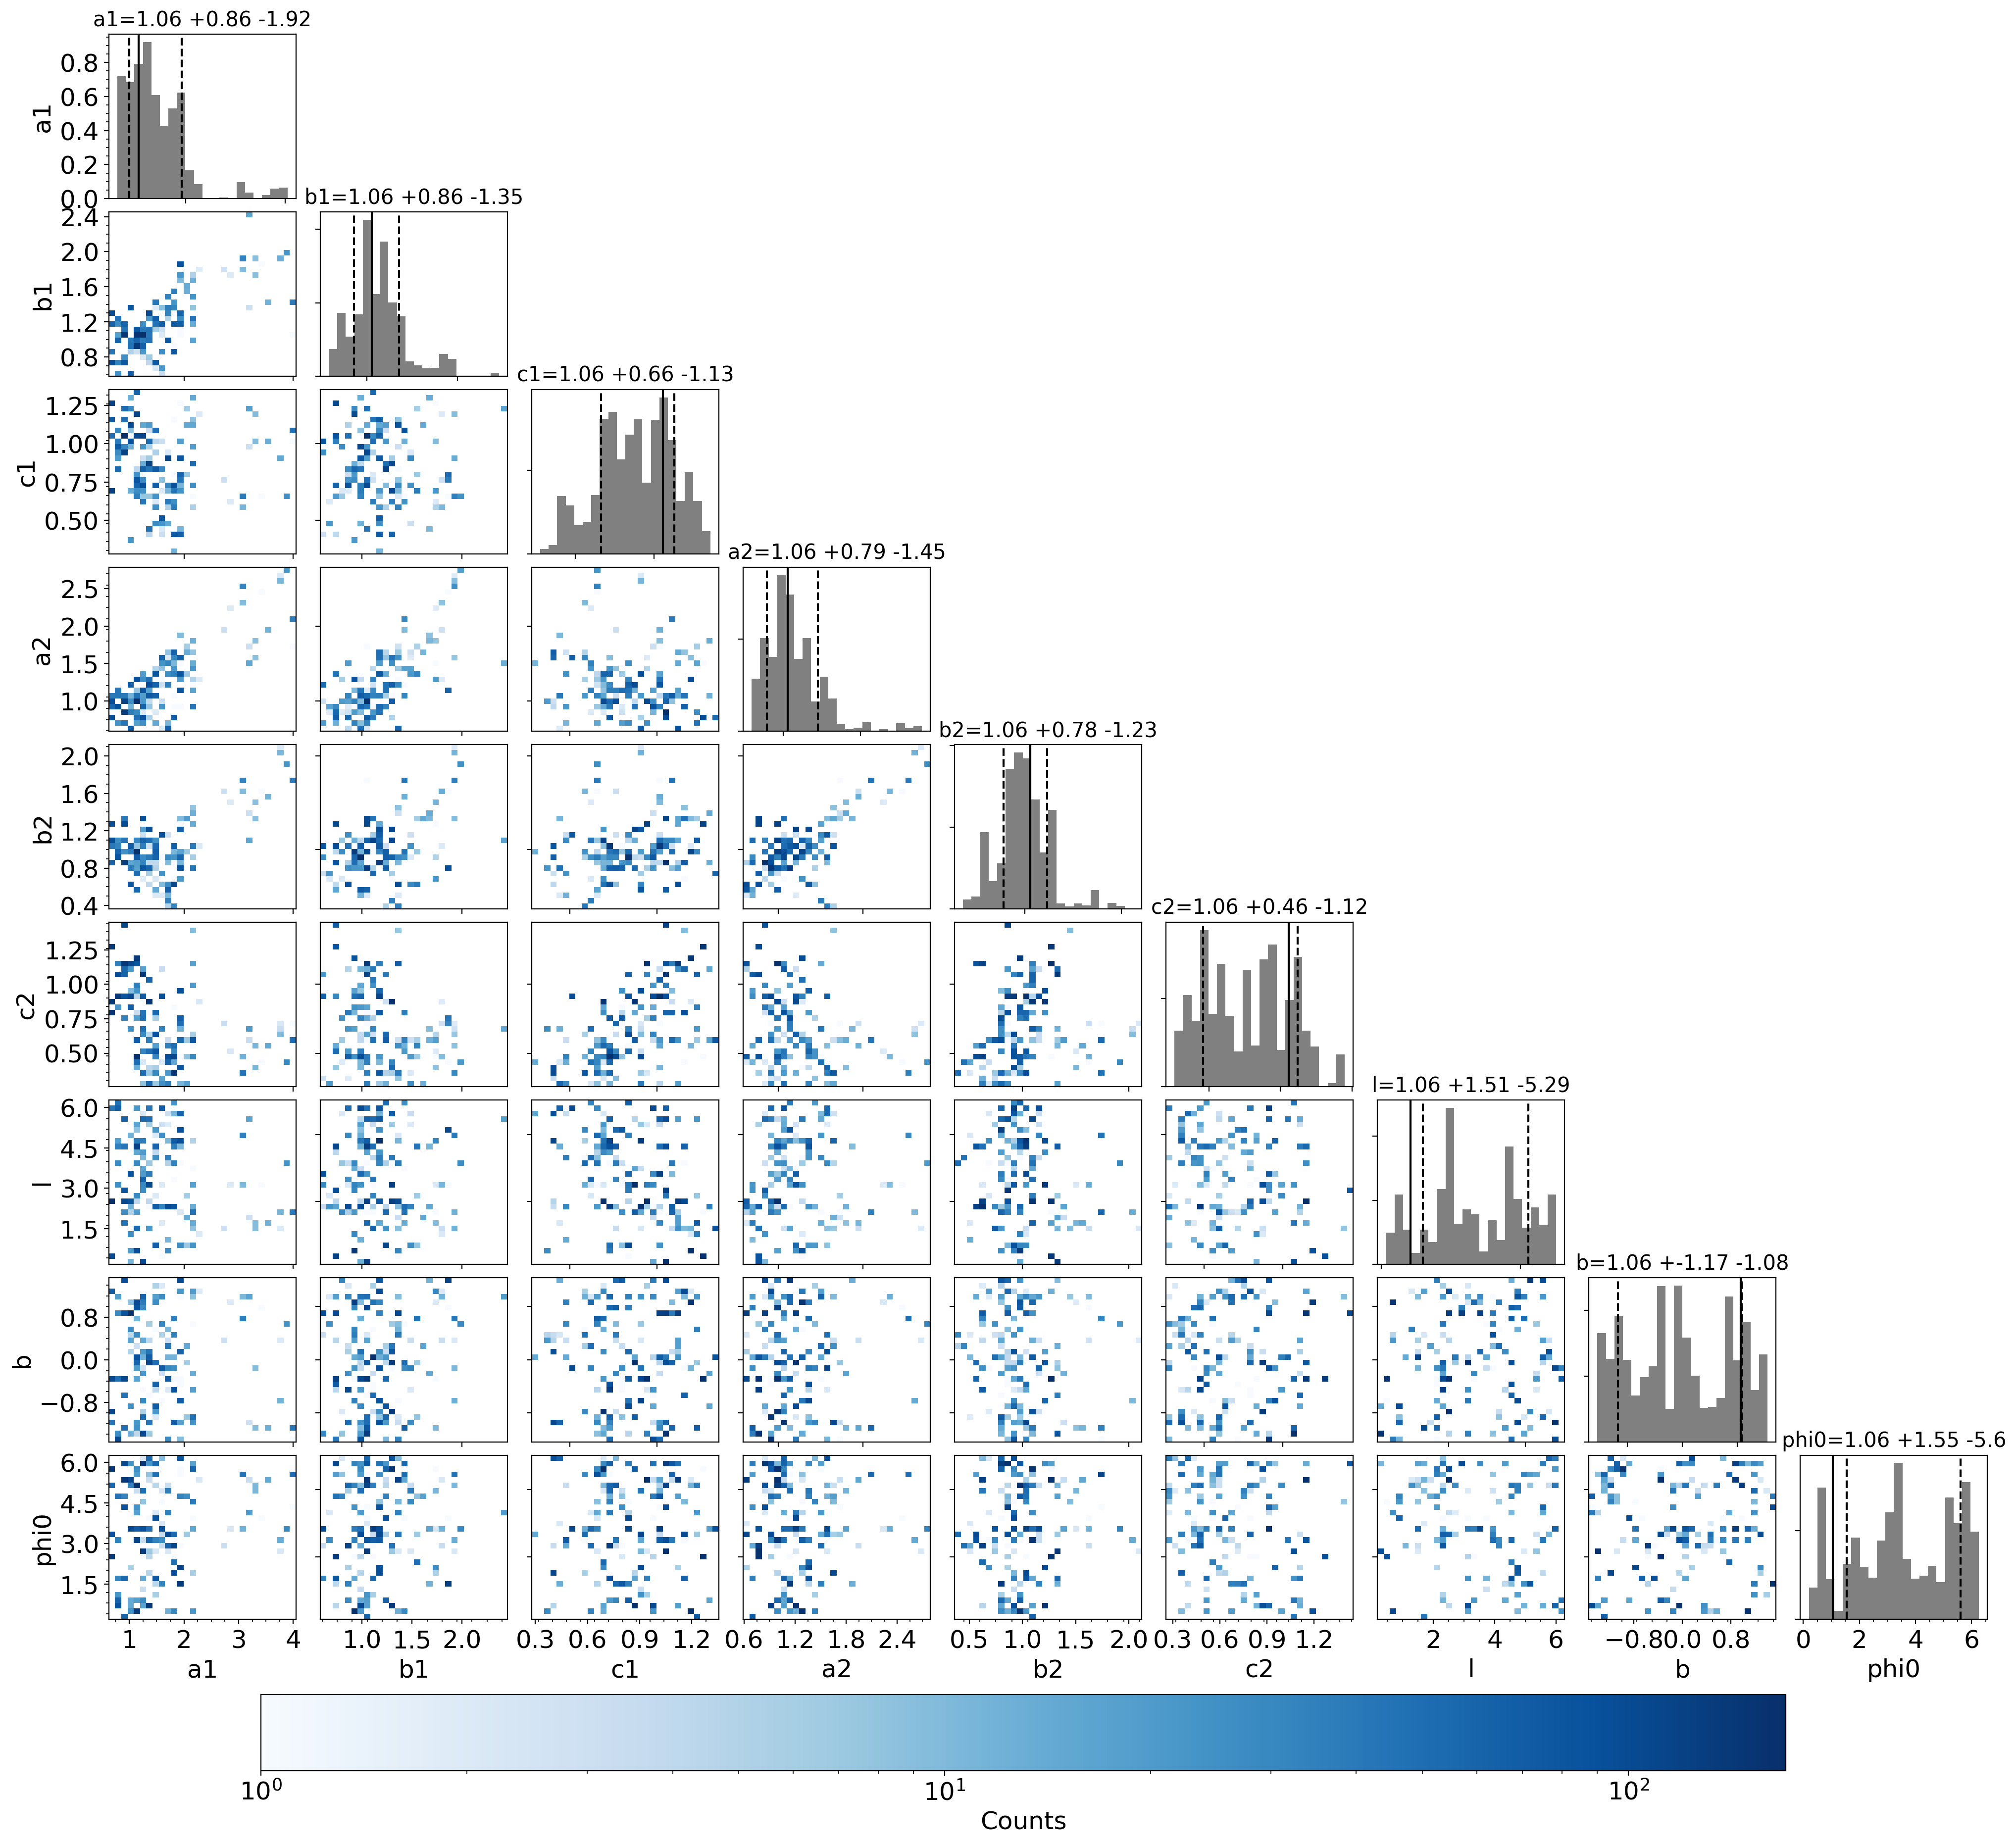

In [9]:
# Number of parameters
from matplotlib.colors import LogNorm
import matplotlib.ticker as ticker

data = samples
num_params = data.shape[1]
labels=["a1", "b1", "c1", "a2", "b2", "c2", "l", "b", "phi0"]

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 15
# Create a figure with subplots
fig, axes = plt.subplots(num_params, num_params, figsize=(20, 20), dpi=200)
bins_heat = 30
bins_hist = 20

# Variable to store the mappable object for the colorbar
mappable = None
# Plot the histograms and scatter plots
for i in range(num_params):
    for j in range(num_params):
        if i < j:
            # Skip the upper triangle and diagonal
            axes[i, j].axis('off')
        elif i == j:
            # Diagonal: plot histograms
            axes[i, j].hist(data[:, i], bins=bins_hist, color='gray', density=True)
            p16 = np.percentile(data[:, i], 16)
            p84 = np.percentile(data[:, i], 84)
            median = np.median(data)
            axes[i, j].axvline(median, color='black')
            axes[i, j].axvline(p16, color='black', linestyle='--')
            axes[i, j].axvline(p84, color='black', linestyle='--')
            # Add title with median and percentiles
            # axes[i, j].title.set_text(r'{0}=${1}^{2}$_{3}$'.format(labels[i], 
            #                                                        round(median,2), round(p16, 2), round(p84, 2)))
            axes[i, j].title.set_text('{0}={1} +{2} -{3}'.format(labels[i], 
                                                               round(median,2), round(p16, 2), round(p84, 2)))
        else:
            # Off-diagonal: plot scatter plots
            h = axes[i, j].hist2d(data[:, j], data[:, i], bins=bins_heat, cmap='Blues', norm=LogNorm())
            if mappable is None:
                mappable = h[3]  # Store the mappable object for the colorbar
            #axes[i, j].set_xlabel(labels[j])
           
        # Remove labels for cleaner look
        if i < num_params - 1:
            axes[i, j].set_xticklabels([])
        if j > 0:
            axes[i, j].set_yticklabels([])
        
        # Add axis labels
        if i == num_params - 1:
            axes[i, j].set_xlabel(labels[j])
            axes[i, j].xaxis.set_major_locator(ticker.MaxNLocator(4))
            axes[i, j].xaxis.set_minor_locator(ticker.MaxNLocator(15))
        if j == 0:
            axes[i, j].set_ylabel(labels[i])
            axes[i, j].yaxis.set_major_locator(ticker.MaxNLocator(5))
            axes[i, j].yaxis.set_minor_locator(ticker.MaxNLocator(20))


# Add a colorbar at the bottom for all subplots
if mappable:
    cbar = fig.colorbar(mappable, ax=axes, orientation='horizontal', fraction=0.05, pad=-0.25, shrink=2.0)
    cbar.set_label('Counts')

# Adjust layout
plt.tight_layout(pad=0.1, h_pad=-0.4, w_pad=0.0)
plt.show()

chi2 mcmc: 4321.237994
chi2 deg:  7491.725508


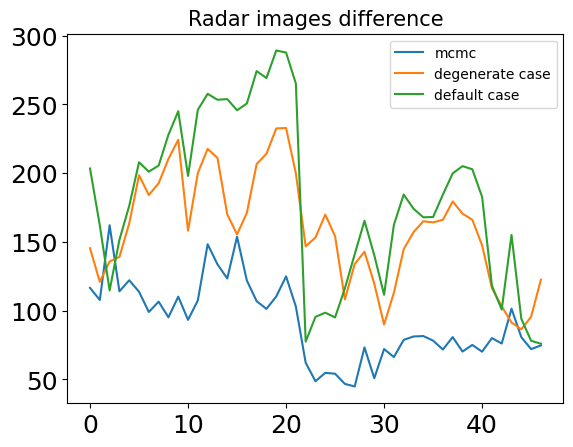

In [14]:
Nalpha=50
dalphadbeta = math.pi**2/Nalpha**2
diff_best, imgs = images_diff(best_params, radar_image_params, radar_images_obs, position_vecs, mult=500)
diff_deg, imgs_deg = images_diff([1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 0, 0, 0], radar_image_params, 
                           radar_images_obs, position_vecs)
diff_def, imgs_def = images_diff([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0], radar_image_params, 
                           radar_images_obs, position_vecs)
plt.title('Radar images difference')
plt.plot(diff_best, label='mcmc')
plt.plot(diff_deg, label='degenerate case')
plt.plot(diff_def, label='default case')
plt.legend()
print(f'chi2 mcmc: {np.sum(diff_best):2f}',)
print(f'chi2 deg:  {np.sum(diff_deg):2f}')

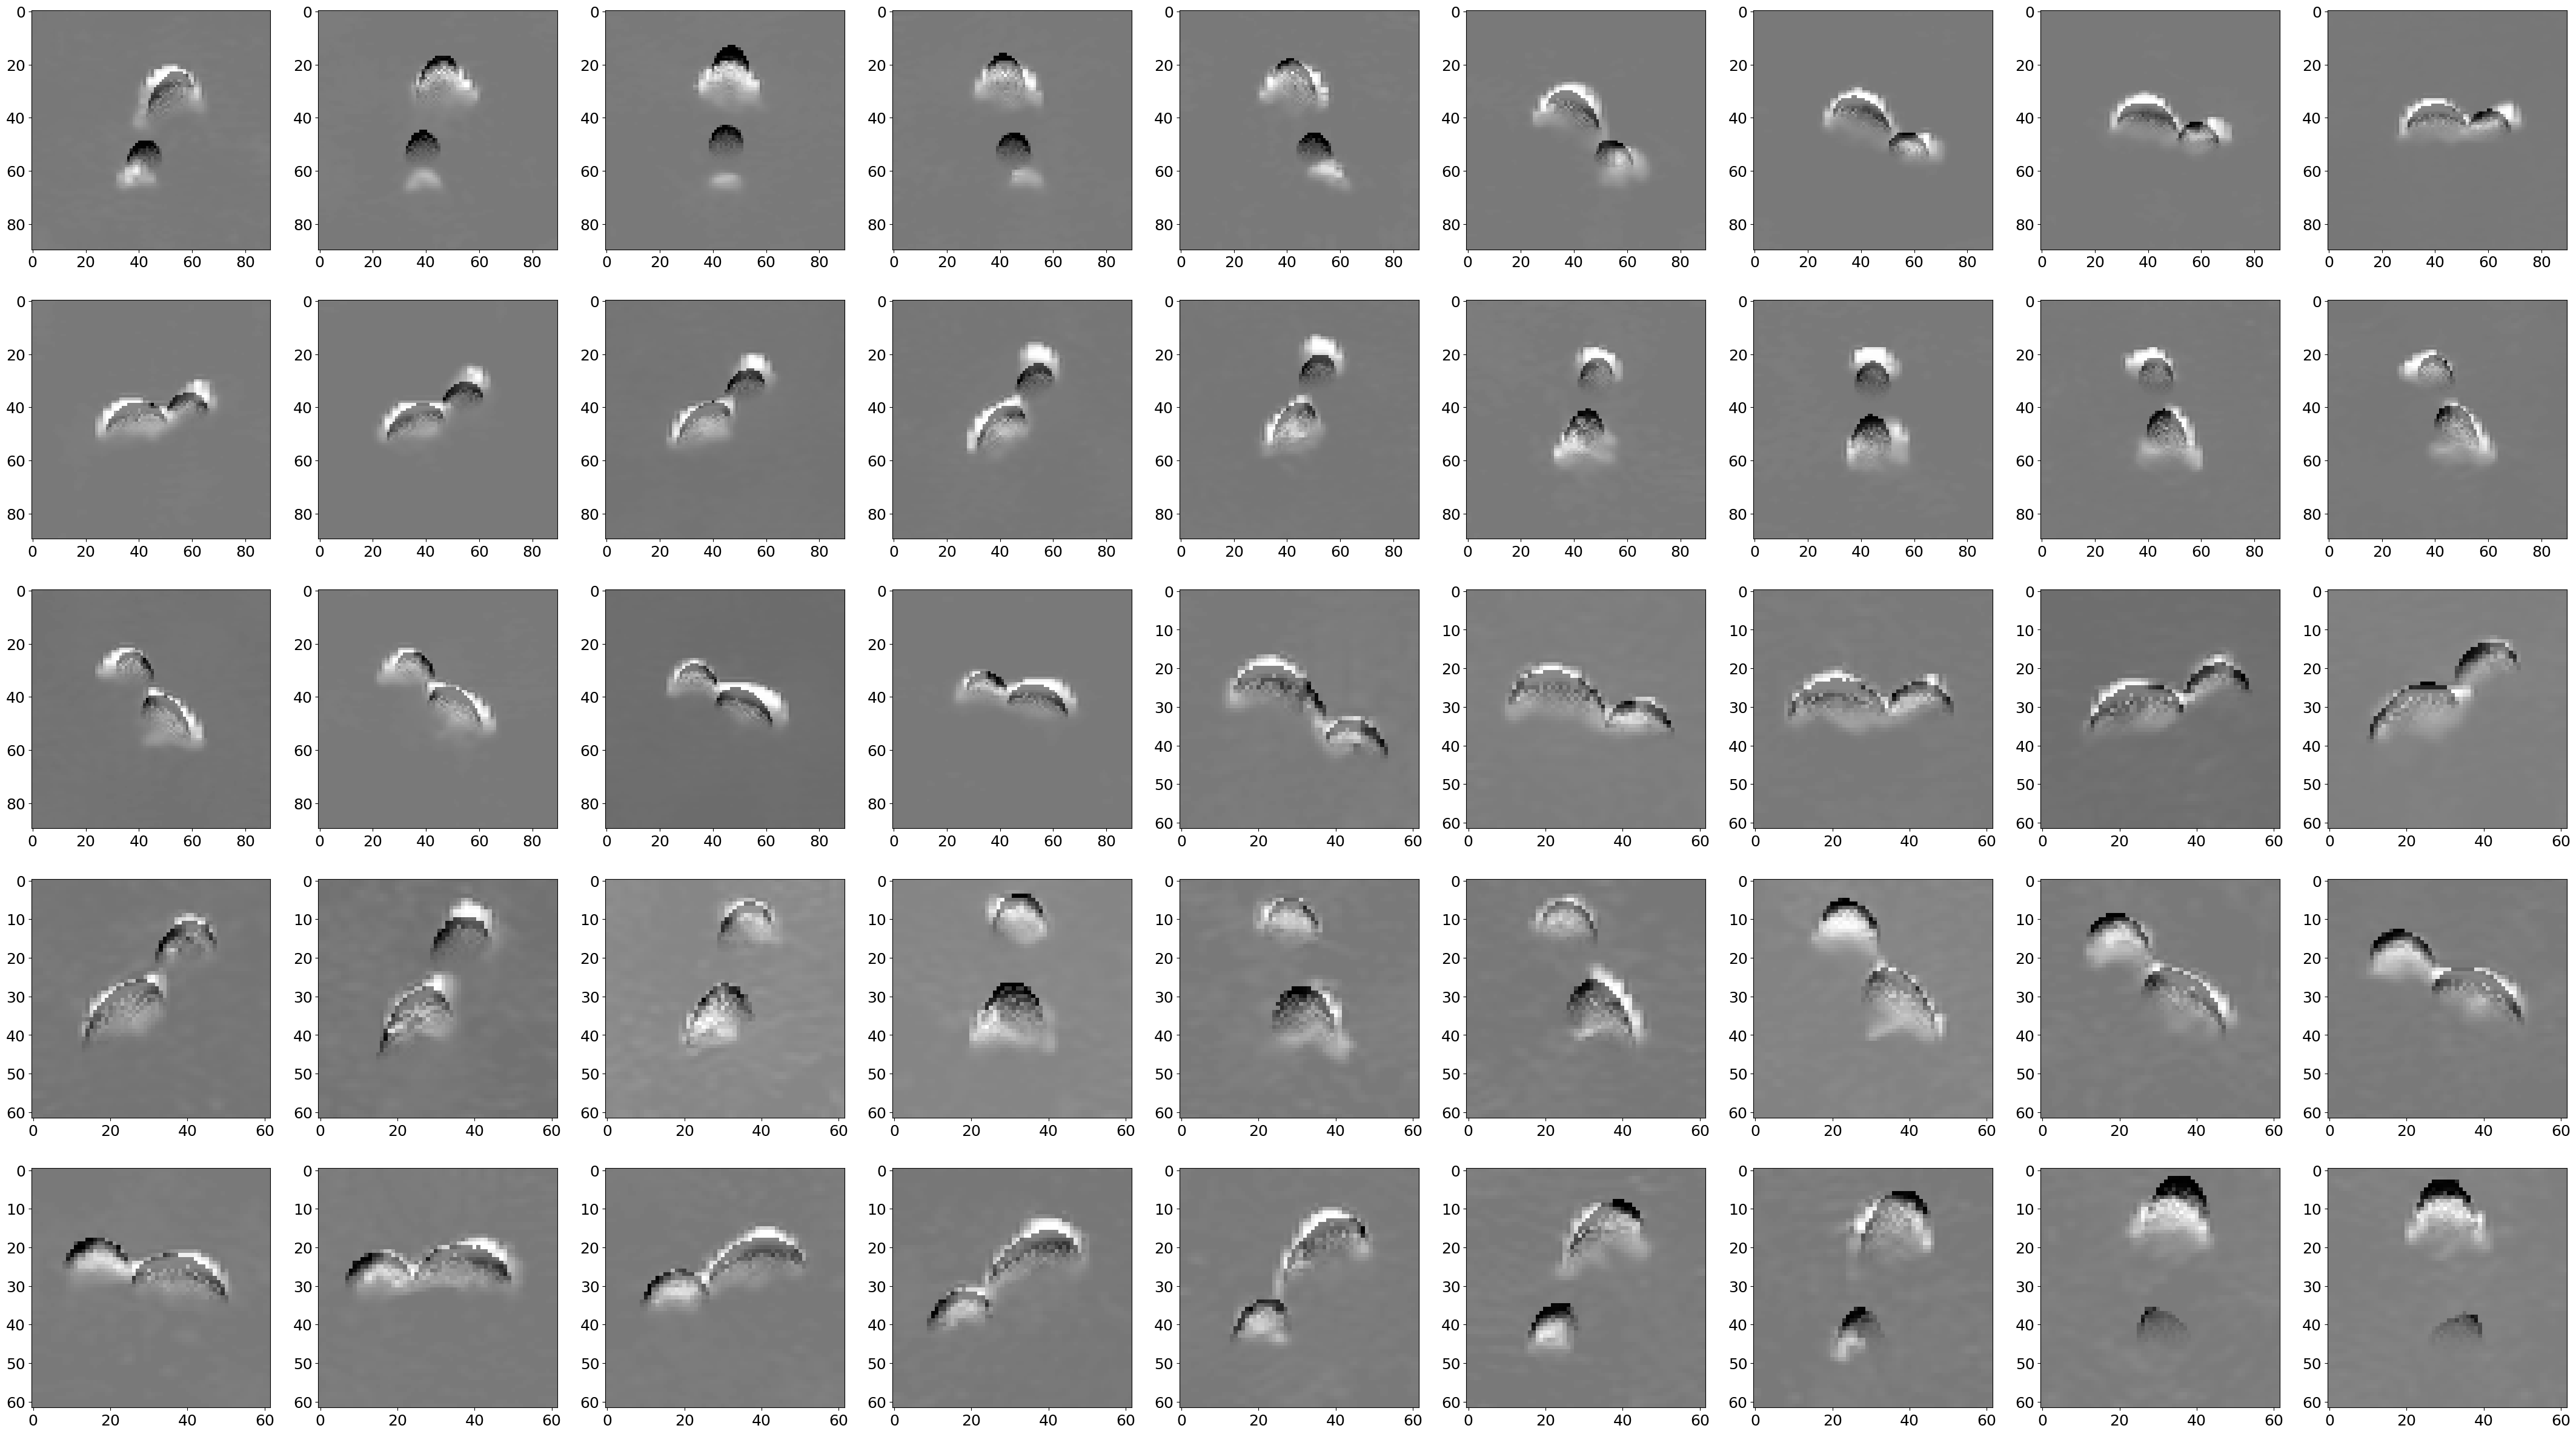

In [15]:
rows = 5
cols = 9
fig, axarr = plt.subplots(rows, cols, figsize=(6 * cols, 6 * rows), dpi=100)
for idx_img in range(0, 45):
    # use the created array to output your multiple images. In this case I have stacked 4 images vertically
    axarr[idx_img // cols][idx_img % cols].imshow(imgs[idx_img], cmap='gray', interpolation='nearest')
plt.show()

In [16]:
lightcurve_theor = theor_curve(params=best_params, earth_data=earth_data, sun_data=sun_data)
# calculate how much the part of the observational curve have to be shifted up/down
lightcurve.calculate_shifts(other=lightcurve_theor)
# shift observed data (lightcurves) by the amount of vertical shift
lightcurve.shift_curves()

χ^2_part0 = 6688.3,
χ^2 total = 61292.2


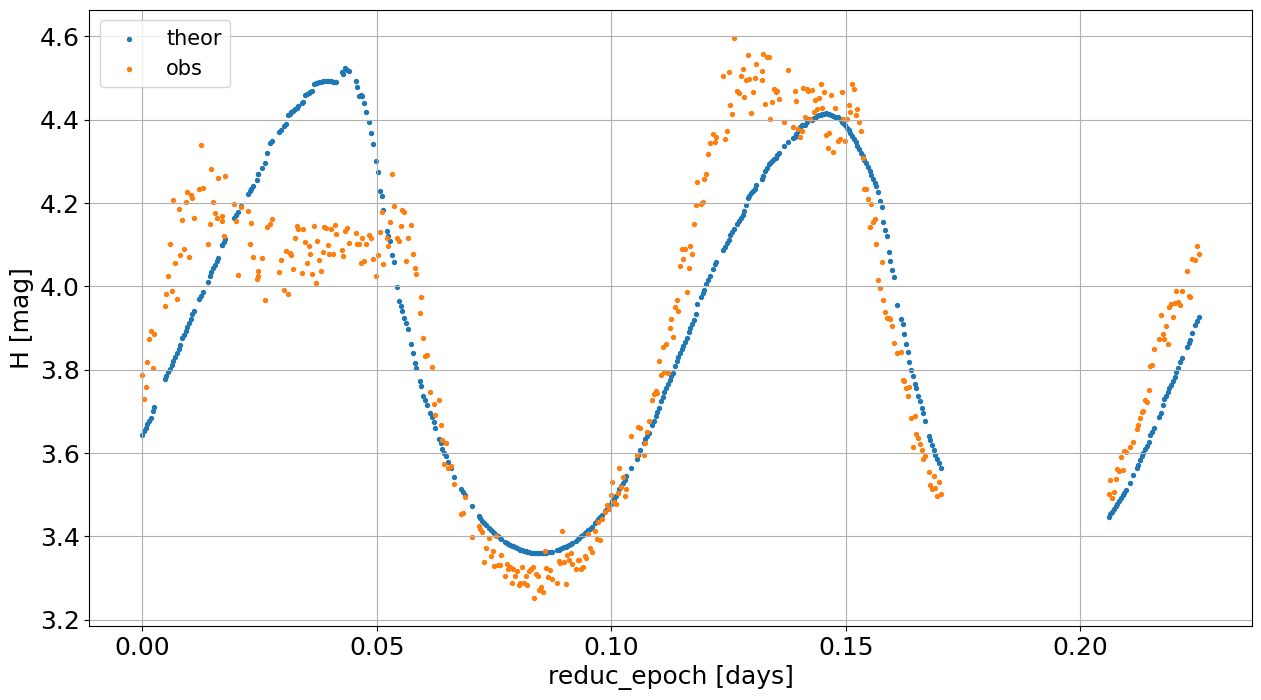

In [17]:
plt.figure(figsize=(15, 8))
idx = 0
lc = lightcurve.lightcurves[idx].data
plt.scatter(sun_data[idx]['reduc_epoch'], lightcurve_theor[idx], s=8, label='theor')
plt.scatter(sun_data[idx]['reduc_epoch'], lightcurve.lightcurves[idx].data['mag_shifted'], s=8, label='obs')

plt.xlabel('reduc_epoch [days]')
plt.ylabel('H [mag]')
plt.legend(loc='upper left', prop = { "size": 15 })
plt.grid()
# calculate chi-squared
chi2_part = np.sum((lc['mag_shifted'] 
               - lightcurve_theor[idx]) ** 2 / lc['mag_err']  ** 2)
# calculate chi-squared
chi2 = np.sum((lightcurve.joined['mag_shifted'] 
               - lightcurve_theor.joined) ** 2 / lightcurve.joined['mag_err'] ** 2)
print(f"\u03C7^2_part{idx} = {chi2_part:.1f},\n\u03C7^2 total = {chi2:.1f}") 

In [78]:
len(samples)

360000

(array([0.70963907, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.35481953, 0.        ,
        0.        , 0.        , 0.70963907, 0.        , 0.17740977,
        0.        , 0.73724403, 2.96146576, 0.55912462, 0.17740977]),
 array([5.33127088, 5.487845  , 5.64441912, 5.80099323, 5.95756735,
        6.11414147, 6.27071559, 6.42728971, 6.58386382, 6.74043794,
        6.89701206, 7.05358618, 7.2101603 , 7.36673441, 7.52330853,
        7.67988265, 7.83645677, 7.99303089, 8.149605  , 8.30617912,
        8.46275324]),
 <BarContainer object of 20 artists>)

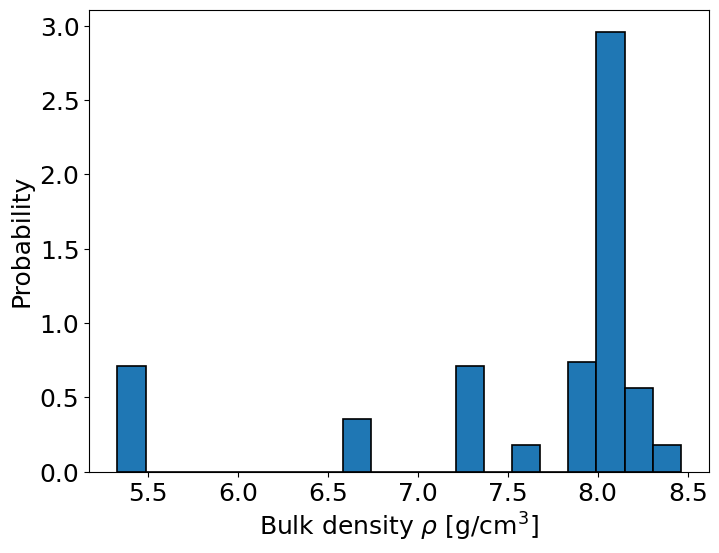

In [79]:
# calculate the density for the asteroid
density = func.estimate_density(*samples[180000:, :6].T, rot_per=5.022)
plt.figure(figsize=(8, 6))
plt.xlabel(r"Bulk density $\rho$ [g/cm$^3$]")
plt.ylabel("Probability")
plt.hist(density, bins=20, edgecolor='black', linewidth=1.2, density=True)